In [31]:
#Clean data
import pandas as pd

df = pd.read_excel("~/Desktop/Research/LMU_Wellness/data/Wellness_Database_May19.xlsx", sheet_name="Wellness Responses")

df = df.dropna(subset=["How well did you hydrate?"])

sore_areas = ["Neck", "Back", "Shoulders", "Chest", "Arms", "Hip Flexors", "Glutes", "Hamstrings", "Quadricps", "Adductors", "Calves", "Feet"]

columns_to_drop = ['Timestamp', 'Athlete ID #', 'Data ID', 'Week ID', 'Week ID Refined', 'Date Value', 'Year ID', 'Season ID', 'Injury Refined', 'Position', 'Classification', 'Stress RA', 'Stress StdDev', 'Stress Z-Score', 'Stress Wellness Score', 'Sleep Quality RA', 'Sleep Quality StdDev', 'Sleep Quality Z-Score', 'Sleep Quality Wellness Score', 'Sleep Quantity RA', 'Sleep Quantity StdDev', 'Sleep Quantity Z-Score', 'Sleep Quantity Wellness Score', 'Soreness RA', 'Soreness StdDev', 'Soreness Z-Score', 'Soreness Wellness Score', 'Hydrate RA', 'Hydrate StdDev', 'Hydrate Z-Score', 'Hydrate Wellness Score', 'Fuel RA', 'Fuel StdDev', 'Fuel Z-Score', 'Fuel Wellness Score', 'Readiness Score']
df = df.drop(columns_to_drop, axis=1)

df['No Injury'] = ((df['What is your injury status?'] == 'Full = I have no injury').astype(int))*10
df['Some Injury'] = ((df['What is your injury status?'] == 'Limited = I need a modification during lift / practice').astype(int))*10
df['Injury'] = ((df['What is your injury status?'] == 'Out = I have an injury').astype(int))*10

for area in sore_areas:
    df[area] = df.apply(lambda row: row["How sore are you?"] / (row["Select where you are sore:"].count(",")+1) if (isinstance(row["Select where you are sore:"], str) and area in row["Select where you are sore:"]) else 0, axis=1)
    
# Drop the original "Select where you are sore:" column
df = df.drop("Select where you are sore:", axis=1)

# Drop the original column
df = df.drop('What is your injury status?', axis=1)
df = df.rename(columns={"Athlete Name": "AthleteName"})

In [32]:
#Remove outliers
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import OLSInfluence

# Prepare the data
X = df.drop(["What is your readiness score? ", "AthleteName"], axis=1)  # Features
y = df["What is your readiness score? "]  # Target variable

# Add a constant term to the features
X = sm.add_constant(X)

# Fit the ordinary least squares (OLS) model
model = sm.OLS(y, X)
results = model.fit()

# Compute leverage values
leverage = OLSInfluence(results).hat_matrix_diag

# Compute Cook's distance
cooks_d = OLSInfluence(results).cooks_distance[0]

# Set a threshold for identifying influential points
threshold = 4 / len(X)  # You can adjust the threshold as needed

# Identify influential points based on Cook's distance and leverage
influential_points = np.where((cooks_d > threshold) | (leverage > np.mean(leverage) + 2 * np.std(leverage)))

# Remove values
for i in range(len(influential_points[0])):
    df = df.drop(index = (influential_points[0][i]+1061) ) 

/Users/gbutts/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [33]:
df['What is your readiness score? '].mean()

80.63839285714286

In [34]:
df['What is your readiness score? '].median()

82.0

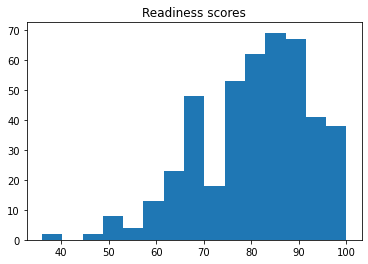

In [35]:
import matplotlib.pyplot as plt

plt.hist(df['What is your readiness score? '], bins='auto')
plt.title("Readiness scores")
plt.show()

#Cut off rate: 75
#The average partially injured athlete is not equipped to train/perform, so 
#the average of partially injured athletes is used as cut off

In [36]:
# Set values above 75 to 1 and values at or below 75 to 0
df['What is your readiness score? '] = np.where(df['What is your readiness score? '] > 75, 1, 0)
df

,AthleteName,How stressed are you?,How well did you sleep?,How many hours did you sleep?,How sore are you?,How well did you hydrate?,How well did you fuel?,What is your readiness score?,No Injury,Some Injury,...,Shoulders,Chest,Arms,Hip Flexors,Glutes,Hamstrings,Quadricps,Adductors,Calves,Feet
1061,Makiya Christensen,7,7,9.0,6,6.0,6.0,0,0,10,...,0.857143,0.0,0.857143,0.857143,0.00,0.857143,0.000000,0.857143,0.0,0.000000
1062,Ellie Sommers,9,9,8.0,9,9.0,8.0,1,10,0,...,0.000000,0.0,0.000000,2.250000,2.25,2.250000,2.250000,0.000000,0.0,0.000000
1064,Alice Santen,6,9,9.0,5,7.0,7.0,0,10,0,...,0.000000,0.0,1.666667,0.000000,0.00,1.666667,1.666667,0.000000,0.0,0.000000
1065,Kailey Park,9,9,9.0,5,7.0,8.0,1,10,0,...,0.000000,0.0,0.000000,2.500000,0.00,2.500000,0.000000,0.000000,0.0,0.000000
1066,Genevieve Watkins,4,8,8.0,4,3.0,2.0,0,10,0,...,1.000000,0.0,0.000000,0.000000,0.00,0.000000,1.000000,1.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1542,Alice Santen,7,9,8.0,8,6.0,7.0,0,10,0,...,0.000000,0.0,0.000000,0.000000,0.00,4.000000,4.000000,0.000000,0.0,0.000000
1543,Bella Beltran,10,10,8.0,4,10.0,10.0,0,10,0,...,0.000000,0.0,0.000000,1.333333,0.00,1.333333,1.333333,0.000000,0.0,0.000000
1544,Gabriella Marchal,10,10,8.0,8,10.0,10.0,1,10,0,...,0.000000,0.0,0.000000,0.000000,0.00,4.000000,0.000000,0.000000,4.0,0.000000
1545,Makiya Christensen,6,8,9.0,5,8.0,7.0,1,10,0,...,0.714286,0.0,0.714286,0.714286,0.00,0.714286,0.714286,0.000000,0.0,0.714286


In [39]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Split the data into training and testing sets
X = df.drop(['What is your readiness score? ', 'AthleteName'], axis=1)  # Features
y = df['What is your readiness score? ']  # Target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Calculate accuracy score
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.6777777777777778


/Users/gbutts/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [41]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

# Split the data into training and testing sets
X = df.drop(['What is your readiness score? ', 'AthleteName'], axis=1)  # Features
y = df['What is your readiness score? ']  # Target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train the logistic regression model with increased max_iter
model = LogisticRegression(max_iter=1000)
model.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred = model.predict(X_test_scaled)

# Calculate accuracy score
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.6777777777777778


In [18]:
nonfeatures = list(set(df.columns) - set(['How stressed are you?', 'How well did you sleep?', 'How many hours did you sleep?', 'How sore are you?', 'How well did you fuel?', 'Back', 'Shoulders', 'Chest', 'Hip Flexors', 'Glutes', 'Hamstrings', 'Quadricps', 'Calves', 'Feet', 'No Injury']))

# Split the data into training and testing sets
X = df.drop(nonfeatures, axis=1)  # Features
best_score = -float('inf')

for n in range(10000):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=n)

    # Scale the features using StandardScaler
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Train the logistic regression model with increased max_iter
    model = LogisticRegression(max_iter=1000)
    model.fit(X_train_scaled, y_train)

    # Predict on the test set
    y_pred = model.predict(X_test_scaled)

    score = model.score(X_test, y_test)
    
    if score > best_score:
        best_score = score
        best_n = n
        best_model = model

print(best_score)

0.8333333333333334
